In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as T
import albumentations as A
import seaborn as sns
%matplotlib inline

In [2]:
GPU = True
device = "cuda" if GPU and torch.cuda.is_available() else "cpu"
print(f'Using device {device}')

Using device cuda


In [3]:
images_path = Path('/content/drive/MyDrive/images')
anno_path = Path('/content/drive/MyDrive/annotations')

In [4]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [5]:
df_train = generate_train_df(anno_path)

In [6]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/images/Cats_Test609.png,500,375,dog,55,91,385,270
1,/content/drive/MyDrive/images/Cats_Test856.png,338,500,dog,46,66,298,253
2,/content/drive/MyDrive/images/Cats_Test771.png,500,333,cat,229,36,315,132
3,/content/drive/MyDrive/images/Cats_Test779.png,500,333,dog,171,51,292,203
4,/content/drive/MyDrive/images/Cats_Test3309.png,300,224,dog,90,9,238,124


In [7]:
class_dict = {'dog': 0, 'cat': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [8]:
print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/images/Cats_Test609.png,500,375,0,55,91,385,270
1,/content/drive/MyDrive/images/Cats_Test856.png,338,500,0,46,66,298,253
2,/content/drive/MyDrive/images/Cats_Test771.png,500,333,1,229,36,315,132
3,/content/drive/MyDrive/images/Cats_Test779.png,500,333,0,171,51,292,203
4,/content/drive/MyDrive/images/Cats_Test3309.png,300,224,0,90,9,238,124


In [9]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [10]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

In [11]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [13]:
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [14]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/drive/MyDrive/images/Cats_Test609.png,500,375,0,55,91,385,270,/content/drive/MyDrive/images_resized/Cats_Tes...,"[72.0, 49.0, 215.0, 344.0]"
1,/content/drive/MyDrive/images/Cats_Test856.png,338,500,0,46,66,298,253,/content/drive/MyDrive/images_resized/Cats_Tes...,"[39.0, 60.0, 151.0, 394.0]"
2,/content/drive/MyDrive/images/Cats_Test771.png,500,333,1,229,36,315,132,/content/drive/MyDrive/images_resized/Cats_Tes...,"[32.0, 204.0, 118.0, 281.0]"
3,/content/drive/MyDrive/images/Cats_Test779.png,500,333,0,171,51,292,203,/content/drive/MyDrive/images_resized/Cats_Tes...,"[45.0, 152.0, 182.0, 260.0]"
4,/content/drive/MyDrive/images/Cats_Test3309.png,300,224,0,90,9,238,124,/content/drive/MyDrive/images_resized/Cats_Tes...,"[11.0, 133.0, 166.0, 354.0]"


In [15]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(500, 375, 3)


In [16]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 70.,  45., 258., 248.], dtype=float32)

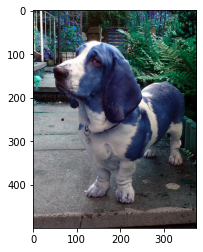

In [17]:
plt.imshow(im)

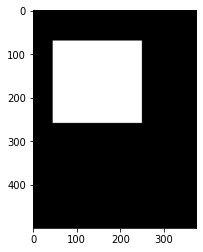

In [18]:
plt.imshow(Y, cmap='gray')

In [19]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [20]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [21]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

/content/drive/MyDrive/images_resized/Cats_Test3509.png


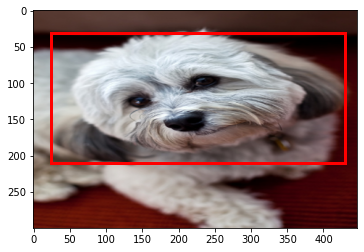

In [22]:
number = 45
im = cv2.imread(str(df_train.values[number][8]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[number][9])

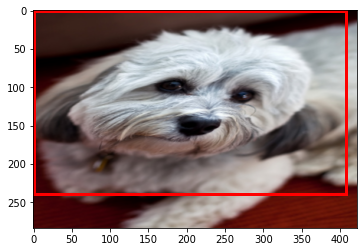

In [23]:
im, bb = transformsXY(str(df_train.values[number][8]),df_train.values[number][9],True )
show_corner_bb(im, bb)

In [24]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [25]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [26]:
class C_D_Dataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [27]:
train_ds = C_D_Dataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = C_D_Dataset(X_val['new_path'],X_val['new_bb'],y_val)

In [28]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [29]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [30]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
epochs = 15

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [31]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
#         print(y_bb.shape)
#         print(y_class.shape)
        out_class, out_bb = model(x)
#         print(out_bb.shape)
#         print(out_class.shape)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 1.159 val_loss 0.889 val_acc 0.629
train_loss 0.906 val_loss 1.340 val_acc 0.577
train_loss 0.879 val_loss 0.849 val_acc 0.663
train_loss 0.838 val_loss 1.086 val_acc 0.614
train_loss 0.819 val_loss 0.805 val_acc 0.665
train_loss 0.798 val_loss 0.802 val_acc 0.687
train_loss 0.788 val_loss 0.874 val_acc 0.663
train_loss 0.781 val_loss 0.823 val_acc 0.694
train_loss 0.765 val_loss 0.820 val_acc 0.695
train_loss 0.758 val_loss 0.768 val_acc 0.692
train_loss 0.747 val_loss 0.760 val_acc 0.682
train_loss 0.737 val_loss 0.773 val_acc 0.686
train_loss 0.732 val_loss 0.802 val_acc 0.688
train_loss 0.710 val_loss 0.738 val_acc 0.726
train_loss 0.702 val_loss 0.774 val_acc 0.703


In [32]:
for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = 0.001

In [33]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
#         print(out_bb.shape)
#         print(out_bb.shape)
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 0.661 val_loss 0.659 val_acc 0.762
train_loss 0.640 val_loss 0.672 val_acc 0.753
train_loss 0.626 val_loss 0.622 val_acc 0.794
train_loss 0.609 val_loss 0.635 val_acc 0.785
train_loss 0.601 val_loss 0.621 val_acc 0.793
train_loss 0.588 val_loss 0.620 val_acc 0.772
train_loss 0.579 val_loss 0.653 val_acc 0.780
train_loss 0.559 val_loss 0.624 val_acc 0.791
train_loss 0.540 val_loss 0.586 val_acc 0.779
train_loss 0.526 val_loss 0.612 val_acc 0.798
train_loss 0.508 val_loss 0.545 val_acc 0.828
train_loss 0.485 val_loss 0.541 val_acc 0.798
train_loss 0.472 val_loss 0.574 val_acc 0.813
train_loss 0.462 val_loss 0.559 val_acc 0.799
train_loss 0.440 val_loss 0.532 val_acc 0.829


## Тестирование

In [46]:
# resizing test image
im = read_image('/content/drive/MyDrive/images_resized/Cats_Test1050.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/content/drive/MyDrive/images_resized/Cats_Test1050.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [47]:
# test Dataset
test_ds = C_D_Dataset(pd.DataFrame([{'path':'/content/drive/MyDrive/images_resized/Cats_Test1050.png'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [48]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [49]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 1.2071,  0.6130, -6.8120, -6.7158]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[ 70.4602, 173.4975, 150.0627, 256.0158]], device='cuda:0',
        grad_fn=<AddmmBackward>))

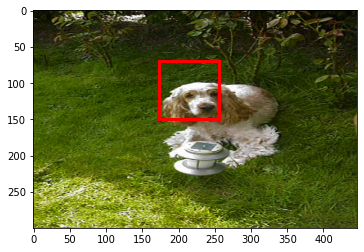

In [50]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])